# импорты

In [1]:
# Импорт модуля для сохранения пайплайна
import os
import joblib

In [2]:
# Импортируем классы для создания пайплайна
from pipeline_classes import *

In [3]:
# Убираем необязательные предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настраиваем полное отображение всех строк таблицы
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Скрываем журнал с триалами
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Загрузка данных

In [4]:
import os
import sys

sys.path += [os.path.abspath("..")]
import pandas as pd
import functions.unifyer as uf

In [5]:
f1 = pd.read_csv("../data/existing_datasets/final_df.csv")
f2 = pd.read_csv("../final_p2.2.csv")
f1 = f1[f2.columns]
print(f1.shape, f2.shape)

(1130, 43) (2200, 43)


In [6]:
# s2 = pd.read_csv("../start_p2.csv")
# condition = (s2["formula"].apply(uf.is_valid_formula) * \
#              (f2[["X", "IR", "pot2"]].isna().sum(axis=1) != 3) * \
#               s2[["formula", "activity"]].notna().sum(axis=1) == 2 * \
#              )
# f2 = f2[condition]
f2 = f2[((f2["activity"] != "multi-activity") * (~f2["activity"].isna()))]
print(f2.shape)

(2174, 43)


In [7]:
df = pd.concat([f1.fillna(0), f2.fillna(0)], ignore_index=True)
df = df.drop(columns=["id"])
df.shape

(3304, 42)

In [8]:
# Загружаем список входных признаков, коррелирующих с целевым
with open("corr_with_activity2.2.txt", "r") as file_activity:
    corr_with_activity = file_activity.read().splitlines()

print(f'Количество коррелирующих признаков: {len(corr_with_activity)}')
print(corr_with_activity)

Количество коррелирующих признаков: 23
['MolWt', 'VSA_EState8', 'dstr', 'MinPartialCharge', 'MinAbsEStateIndex', 'PEOE_VSA8', 'Kappa2', 'pot2', 'MaxPartialCharge.1', 'EState_VSA4', 'MinEStateIndex', 'temp', 'Cconst', 'IR', 'lgCcat', 'X', 'Ccat', 'Complexity1', 'TPSA1', 'ph', 'MaxEStateIndex.1', 'MaxEStateIndex.2', 'MinPartialCharge.1']


## Предобработка данных

In [9]:
print(f'Размер первоначального датафрейма: {df.shape}')

Размер первоначального датафрейма: (3304, 42)


In [10]:
df['activity'] = df['activity'].replace({1: "peroxidase", 2: "oxidase", 3: "catalase", 4: "laccase"})
category2num = {cat: i+1 for i, cat in enumerate(df['activity'].value_counts().index.tolist())}
print(category2num)
df['activity'] = df['activity'].replace(category2num)

{'peroxidase': 1, 'oxidase': 2, 'catalase': 3, 'superoxide dismutase': 4, 'phosphatase': 5, 'esterase': 6, 'reductase': 7, 'laccase': 8, 'glycosidase': 9, 'uricase': 10, 'dnase': 11, 'rnase': 12, 'hydrolase': 13, 'phosphotriesterase': 14, 'epoxydase': 15}


In [11]:
# Удаляем дубликаты
df = df.drop_duplicates()
print(f'Размер датафрейма после удаления дубликатов: {df.shape}')

Размер датафрейма после удаления дубликатов: (3151, 42)


In [12]:
df['activity'].value_counts()

activity
1     2628
2      313
3      132
4       40
5       11
6        9
8        4
9        4
7        3
10       2
11       1
12       1
13       1
14       1
15       1
Name: count, dtype: int64

In [13]:
# Сохранение примеров только с такими активностями, которые представлены в датасете больше 10 раз
interesting_activities = [1, 2, 3, 4, 5, 6]
df = df[df['activity'].astype(int).isin(interesting_activities)]
# df['activity'] = df['activity'].replace({key: i+1 for i, key in enumerate(interesting_activities)})
print(f'Размер датафрейма после выбора элементов с определёнными activity: {df.shape}')

Размер датафрейма после выбора элементов с определёнными activity: (3133, 42)


In [14]:
# Преобразование типов и замена "no" на NaN
df['Vmax'] = pd.to_numeric(df['Vmax'].replace("no", np.nan), errors='coerce')
df['Km'] = pd.to_numeric(df['Km'].replace("no", np.nan), errors='coerce')

invalid_values = list(df['ph'][~df['ph'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()])
df['ph'] = pd.to_numeric(df['ph'].where(lambda ph: ~ph.isin(invalid_values)), errors='coerce')

# Проверяем что сделали корректно
print(df[['Vmax', 'Km', 'ph']].dtypes)

Vmax    float64
Km      float64
ph      float64
dtype: object


In [15]:
# Оставляем в датафрейме только те признаки, которые коррелируют с целевым
df = df[corr_with_activity + ['activity']]
print(f'Размеры датафрейма: {df.shape}')
print(f'Количество дубликатов после удаления признаков: {df.duplicated().sum()}')
df = df.drop_duplicates()

Размеры датафрейма: (3133, 24)
Количество дубликатов после удаления признаков: 400


In [16]:
df.activity.value_counts()

activity
1    2301
2     266
3     116
4      31
5      10
6       9
Name: count, dtype: int64

In [34]:
len(df.columns)

24

# Generation

In [23]:
df = df.dropna()

In [68]:
from sklearn.preprocessing import MinMaxScaler

In [74]:
skaler = MinMaxScaler()
mmdf = skaler.fit_transform(df.drop(columns=["activity"]))

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [103]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return self.fc3(h)  # Linear output for float values

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # print(MSE, KLD)
    return (MSE + KLD)

tensor_data = torch.tensor(mmdf, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(tensor_data), batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = len(df.columns) - 1
model = VAE(input_dim=input_dim, hidden_dim=16, latent_dim=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 20):
    model.train()
    total_loss = 0
    for batch in dataloader:
        # print(batch)
        batch = batch[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {total_loss / len(df):.4f}")


Epoch 1, Loss: 2.7163
Epoch 2, Loss: 0.7234
Epoch 3, Loss: 0.5146
Epoch 4, Loss: 0.4663
Epoch 5, Loss: 0.4486
Epoch 6, Loss: 0.4372
Epoch 7, Loss: 0.4324
Epoch 8, Loss: 0.4295
Epoch 9, Loss: 0.4282
Epoch 10, Loss: 0.4261
Epoch 11, Loss: 0.4244
Epoch 12, Loss: 0.4245
Epoch 13, Loss: 0.4235
Epoch 14, Loss: 0.4229
Epoch 15, Loss: 0.4227
Epoch 16, Loss: 0.4222
Epoch 17, Loss: 0.4228
Epoch 18, Loss: 0.4225
Epoch 19, Loss: 0.4224


In [105]:
model.eval()
all_hidden = []

with torch.no_grad():
    for data in mmdf:
        x = torch.FloatTensor(data).to(device)
        mu, _ = model.encode(x)
        all_hidden.append(mu.tolist())
all_hidden = np.array(all_hidden)

In [88]:
import matplotlib.pyplot as plt
import numpy as np

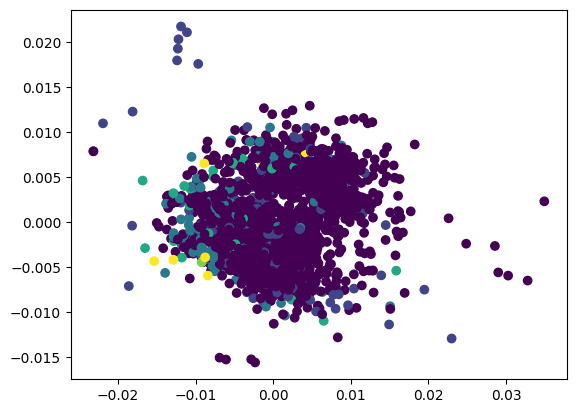

In [106]:
plt.scatter(all_hidden[:, 0], all_hidden[:, 1], c=df["activity"])

In [146]:
model.eval()
with torch.no_grad():
    z = torch.randn(1000000, model.fc_mu.out_features).to(device)  # 1 sample from latent space
    sample = model.decode(z).cpu().numpy()  # Shape: (1, input_dim)
new_data = skaler.inverse_transform(sample)
new_df = pd.DataFrame(new_data, columns=df.drop(columns=["activity"]).columns)
new_df["dstr"] = new_df["dstr"].apply(round)

In [147]:
classifyer = joblib.load("saved_models/full_df2.2/ensemble_model.pkl")

In [148]:
%%time
predictions = classifyer.predict(new_df)

CPU times: user 47.1 s, sys: 2.05 s, total: 49.2 s
Wall time: 43.4 s


In [149]:
np.unique(predictions)

array([1])

In [145]:
new_df

,MolWt,VSA_EState8,dstr,MinPartialCharge,MinAbsEStateIndex,PEOE_VSA8,Kappa2,pot2,MaxPartialCharge.1,EState_VSA4,MinEStateIndex,temp,Cconst,IR,lgCcat,X,Ccat,Complexity1,TPSA1,ph,MaxEStateIndex.1,MaxEStateIndex.2,MinPartialCharge.1
0,143.229507,1.850823,2,-0.273565,0.135196,3.345395,4.626650,0.070867,-0.064271,4.042617,-0.557184,39.076595,73.722603,1.068480,-0.984796,2.462880,0.798765,145.411438,59.308880,4.577349,6.029860,5.336377,-0.308358
1,148.459641,1.479114,2,-0.263079,0.147850,3.346721,4.523658,0.098146,-0.068796,4.045746,-0.490066,40.431793,23.664608,1.091154,-0.828671,2.439021,1.702354,135.582397,48.011753,4.549514,5.809765,5.054164,-0.318930
2,140.853500,1.666520,2,-0.229304,0.146040,2.833387,4.908017,0.065974,-0.044592,3.755740,-0.457912,37.639339,76.175705,1.096269,-0.894793,2.468607,1.821476,136.953156,50.880901,4.631718,6.023633,5.323037,-0.310934
3,138.624893,1.545129,2,-0.252226,0.140510,3.018403,4.650820,0.077034,-0.054991,4.007452,-0.449877,37.966736,85.571335,1.081384,-0.898425,2.487631,0.897681,137.864807,52.184063,4.584907,5.890651,5.101793,-0.318922
4,148.209213,1.788005,2,-0.248433,0.137112,4.020287,4.299437,0.072654,-0.063017,3.620327,-0.454216,43.631748,63.082279,1.091161,-0.947455,2.471439,0.828327,150.042801,61.001965,4.517718,6.084731,5.349496,-0.310715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,140.351501,1.586587,2,-0.246559,0.145130,3.975249,4.435950,0.083209,-0.066963,3.530325,-0.489844,43.544758,95.028130,1.107205,-0.760850,2.494098,1.504001,161.693420,63.087109,4.591080,6.128563,5.096629,-0.288044
99996,134.143402,1.533725,2,-0.247433,0.141742,3.483896,5.123940,0.086164,-0.052824,3.975261,-0.359303,37.344879,113.919823,1.094151,-0.894394,2.523197,0.882360,133.376770,51.712013,4.598268,5.864041,5.083134,-0.328757
99997,129.180435,1.469642,2,-0.254896,0.149535,3.596124,5.245064,0.082035,-0.058941,3.534778,-0.414652,38.130657,100.084991,1.110288,-0.844309,2.502900,2.441761,149.666855,54.309086,4.598780,6.061716,5.192487,-0.313622
99998,170.703079,1.769243,2,-0.332853,0.137710,3.752011,6.758663,0.140430,-0.088426,5.320483,-0.577515,40.770340,107.086525,1.035388,-0.861558,2.460605,1.023319,164.743973,41.211407,4.582903,5.724521,4.709496,-0.306760


In [150]:
from scipy.optimize import minimize

In [218]:
def for_minimization(x, ind):
    return 1 - classifyer.predict_proba(np.array(x).reshape(1, -1))[0][ind]

In [220]:
from collections import defaultdict

In [231]:
generations = defaultdict(list)
for activity_index in range(1, 2):
    for _ in range(30):
        random_index = np.random.randint(new_df.shape[0])
        x0 = new_df.loc[random_index].values
        res = minimize(for_minimization, x0=x0, args=(activity_index), method="COBYLA")
        generations[activity_index].append({"random_index": random_index, "x0": x0, "res": res.x, "fun": res.fun})

In [230]:
generations

defaultdict(list,
            {1: [{'random_index': 442188,
               'x0': array([ 1.44662704e+02,  1.79841101e+00,  2.00000000e+00, -2.80451655e-01,
                       1.40794590e-01,  4.02557564e+00,  6.01248550e+00,  8.66110101e-02,
                      -6.86112419e-02,  4.35466433e+00, -4.63287622e-01,  4.01255722e+01,
                       1.15863907e+02,  1.07377923e+00, -9.74204779e-01,  2.49785829e+00,
                       9.84477103e-01,  1.64275375e+02,  5.58616905e+01,  4.52580929e+00,
                       6.00149488e+00,  5.11851406e+00, -3.03280562e-01]),
               'res': array([ 1.46570874e+02,  2.96428327e+00,  2.57419596e+00, -4.65407770e-01,
                       6.32621856e-01,  3.78256311e+00,  6.86302556e+00,  1.44740509e+00,
                       1.85342753e+00,  5.25769049e+00,  1.38394256e+00,  4.06614741e+01,
                       1.14584304e+02,  8.26425227e-01,  6.29427748e-02,  2.34419909e+00,
                       2.11763920e+00,  1.